<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<center><font size=10>Artificial Intelligence and Machine Learning</font></center>
<center><font size=6>Face Recognition</font></center>

# **Face Recognition**

### **Description**

**Context**
_________________________

Company X owns a movie application and repository that caters to movie streaming to millions of users on a
subscription basis. The company wants to automate the process of cast and crew information in each scene from
a movie such that when a user pauses on the movie and clicks on the cast information button, the app will show
details of the actor in the scene. The company has in-house computer vision and multimedia experts who need to
detect faces from screenshots of the movie scene.


**Objective**

**Part A**: To build a face detection system

**Part B**: To create an image dataset to be used by the AI team to build image classifier data

**Part C**: To build a face recognition system

### Data Dictionary

**Part A**

label: Identifies the object in the image

notes: Additional comments (currently empty)

points: Co-ordinates of the mask (top-left and bottom-right)

imageWidth: Width of the image in pixels

imageHeight: Height of the image in pixels

**Part B**

The dataset comprises facial images that may contain either multiple individuals or a single individual per image.

**Part C**
This dataset consists of 10,770 images collected from Pinterest, featuring 100 individuals.

### Import the required Libraries

In [ ]:
# Import the required libraries
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from datetime import datetime
import random
import os
import zipfile

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# ignore warnnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# config section
IMG_SIZE = 256
MASK_CHANNELS = 1
epochs = 45
batch_size=32
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
threshold=0.40
contour_area=50

distance_threshold_similar = 0.20
distance_threshold_dissimilar = 0.60

### Part I  - Face detection

In [ ]:
#### Part I - Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# path to the dataset of Part A - Images.npy
path_a = "/content/drive/MyDrive/ComputerVision/Images.npy"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the images file numpy array
images_npy = np.load(path_a, allow_pickle=True)

In [ ]:
images_npy.shape

(393, 2)

* There are 393 images in the dataset

#### Part I  - Split the Images Array to Images and Masks

In [ ]:
# lets split the images array to list of images and annotations
all_images = [image[0] for image in images_npy]
all_annotations = [image[1] for image in images_npy]

In [ ]:
# print the random shapes for the images
for i in np.random.randint(0, 393, 5):
  print(f"Index:{i} => Image shape = {images_npy[i][0].shape} ## Number of bounding boxes = {len(images_npy[i][1])}")

Index:102 => Image shape = (449, 800, 3) ## Number of bounding boxes = 3
Index:348 => Image shape = (662, 970, 3) ## Number of bounding boxes = 5
Index:270 => Image shape = (720, 1280, 3) ## Number of bounding boxes = 3
Index:106 => Image shape = (528, 521, 3) ## Number of bounding boxes = 2
Index:71 => Image shape = (1188, 800, 3) ## Number of bounding boxes = 1


*  The size of the images is not uniform.
*  Each image would contain multiple bounding boxes

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
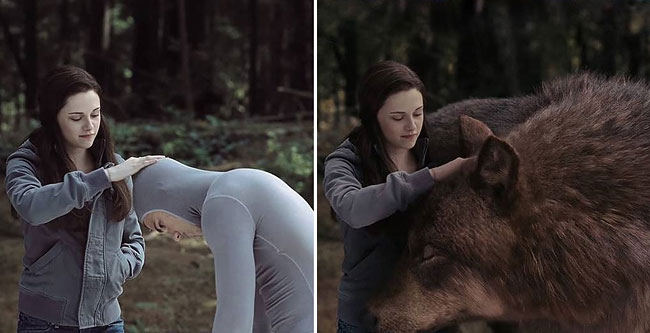

In [ ]:
# visualize the first element
images_npy[0][0]

* The first element is the image with n dimensional numpy array

In [ ]:
# print the second element
images_npy[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

* The second item is a list of dictionaries.
* Each dictionary contains metadata related to a face detected in the image.

In [ ]:
# This function takes the images and does the following tasks
# Makes the images and annotations uniform size
# Normalize the images
# Fill the bounding boxes and convert them as masks
# Returns the images and masks

def load_and_prepare_data(images_npy, img_size=128):

    X = []
    Y = []

    for img, annotations in images_npy:

      # --- Handle grayscale to RGB ---
      if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
      if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)    # (H, W, 3)
      # Convert RGBA to RGB if needed
      if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

      # --- Resize image using TensorFlow ---
      image_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
      resized_image = tf.image.resize(image_tensor, size=(img_size, img_size))
      resized_image = resized_image.numpy().astype(np.uint8)
      X.append(resized_image/255.0)

      # Initialize empty mask
      mask = np.zeros((img_size, img_size), dtype=np.uint8)

      # Draw each bounding box
      for ann in annotations:
          x1 = int(ann['points'][0]['x'] * img_size)
          y1 = int(ann['points'][0]['y'] * img_size)
          x2 = int(ann['points'][1]['x'] * img_size)
          y2 = int(ann['points'][1]['y'] * img_size)
          mask[y1:y2, x1:x2] = 1

      Y.append(mask)

    X = np.array(X)
    Y = np.expand_dims(np.array(Y), axis=-1)
    return X, Y

In [ ]:
# Form the images as input and bounding mask as output
X, y = load_and_prepare_data(images_npy, IMG_SIZE)

In [ ]:
# print the shapes of X and y
print(f"Shape of input image: {X.shape}")
print(f"Shape of output mask: {y.shape}")

Shape of input image: (393, 256, 256, 3)
Shape of output mask: (393, 256, 256, 1)


**Observations** :

* All images are resized to a consistent shape with 3 color channels.

* All masks are resized to a uniform size with a single channel.

### Visualize the images and masks

In [ ]:
# Lets create a function to plot the images, bounding boxes and masks
def plot_inputs_with_mask_and_bboxes(images, masks, bboxes_list, labels_list=None, titles=None):
    """
    For each of 6 images, plots a row of 3:
    - Original image
    - Image with bounding boxes
    - Corresponding mask
    """

    num_images = len(images)
    fig, axs = plt.subplots(num_images, 3, figsize=(10, 2.5 * num_images))

    for i in range(num_images):
        img = images[i]
        mask = masks[i].squeeze()
        bboxes = bboxes_list[i]
        labels = labels_list[i] if labels_list else None
        title = titles[i] if titles else f"Image {i+1}"

        # 1. Original image
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"{title} - Original")
        axs[i, 0].axis('off')

        # 2. Image with BBoxes
        axs[i, 1].imshow(img)
        axs[i, 1].set_title(f"{title} with BBoxes")
        for j, box in enumerate(bboxes):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin

            rect = patches.Rectangle((xmin, ymin), width, height,
                                     linewidth=2, edgecolor='g', facecolor='none')
            axs[i,1].add_patch(rect)

            if labels and j < len(labels):
                axs[i,1].text(xmin, ymin - 5, str(labels[j]), color='white',
                        fontsize=9, bbox=dict(facecolor='green', alpha=0.5))

        axs[i, 1].axis('off')

        # 3. Mask
        axs[i, 2].imshow(mask, cmap='gray')
        axs[i, 2].set_title(f"{title} Segmentation Mask")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# This function returns the bounding box for each face annotation
def get_bounding_box(ann):
  scale_x = IMG_SIZE
  scale_y = IMG_SIZE

  x1 = int(ann['points'][0]['x'] * scale_x)
  y1 = int(ann['points'][0]['y'] * scale_y)
  x2 = int(ann['points'][1]['x'] * scale_x)
  y2 = int(ann['points'][1]['y'] * scale_y)
  xmin, xmax = sorted([x1, x2])
  ymin, ymax = sorted([y1, y2])
  return [xmin, ymin, xmax, ymax]

In [ ]:
# lets take random 4 images from first 274 images
random_indices = np.random.randint(0,274,4)
random_images = []
random_bboxes = []
random_masks = []
for i in random_indices:
  random_images.append(X[i])
  random_masks.append(y[i])
  image_bboxes = []

  for ann in all_annotations[i]:
    image_bboxes.append(get_bounding_box(ann))

  random_bboxes.append(image_bboxes)

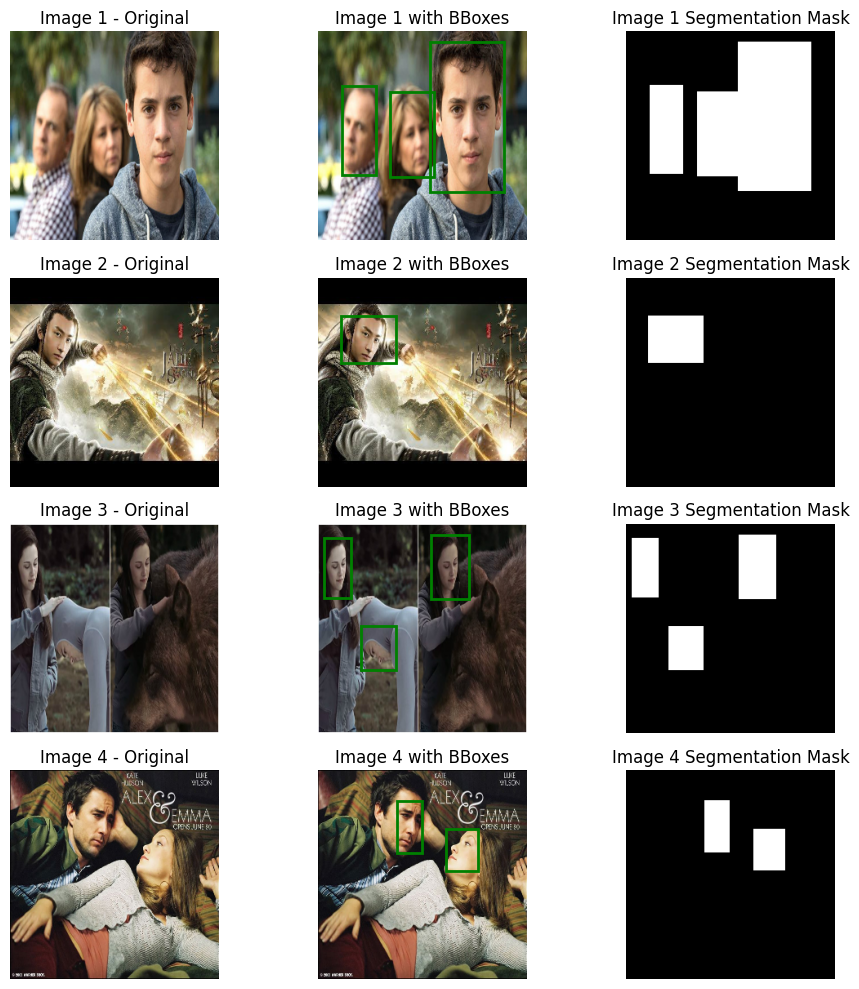

In [ ]:
# plot resized image, bounding box and corresponding segmentation mask
plot_inputs_with_mask_and_bboxes(random_images, random_masks, random_bboxes)

**Observations**:

* The visualization above confirms that the images and their corresponding bounding masks have been resized correctly.

* In certain images, face masks appear merged when faces are positioned very close to each other.

### Part A - Split into Train and Test

In [ ]:
# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
# print the shapes of training datasets
print(f"Train data size : {X_train.shape} : {y_train.shape}")

Train data size : (275, 256, 256, 3) : (275, 256, 256, 1)


In [ ]:
# Split the test images into val and test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

In [ ]:
# print the shapes of val and test datasets
print(f"Validation data size : {X_val.shape} : {y_val.shape}")
print(f"Test data size : {X_test.shape} : {y_test.shape}")

Validation data size : (59, 256, 256, 3) : (59, 256, 256, 1)
Test data size : (59, 256, 256, 3) : (59, 256, 256, 1)


**Observations**:

* The training dataset contains 275 images.

* The following 59 images are used as the validation dataset.

* The subsequent 59 images are allocated to the test dataset.

#### Part I - Design model for Face detection

Lets create the model using the following layers

**Input Layer**:
Specifies the dimensions of the input image, which is 256×256 with 3 color channels (RGB).

**Convolution Block**:
A sequence of two convolutional layers with ReLU activation, separated by a dropout layer (rate = 0.1) to prevent overfitting.

**Contracting Path (Encoder)**:
This path extracts contextual and hierarchical features by progressively reducing the spatial resolution. It consists of four stages, each with a convolution block followed by a max-pooling operation to downsample the feature maps.

**Bottleneck**:
The deepest layer of the U-Net architecture that captures the most abstract and complex features. It serves as a bridge between the encoder and decoder paths.

**Expanding Path (Decoder)**:
This path reconstructs the spatial information and refines segmentation boundaries by upsampling the feature maps. It includes four stages, each comprising a transposed convolution (for upsampling) and a skip connection that merges corresponding encoder features to preserve spatial details.

**Output Layer**:
A final 1×1 convolution reduces the feature map to a single channel suitable for binary segmentation, with a sigmoid activation to output probabilities between 0 and 1.



In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Dropout(0.1)(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D()(c4)

    c5 = conv_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 16)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    return Model(inputs, outputs)

#### Part I - Create dice coefficient and dice loss

Define functions for calculating the Dice coefficient and Dice loss, which will be used during model compilation.

In [ ]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
# Combine BCE and Dice
def combined_bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

#### Part I - Train the model

Train the model with combined dice coeffiecient and dice loss

In [ ]:
# Function to compile the model
def train_unet_model():
    model = unet_model()
    model.compile(optimizer='adam',
              loss=combined_bce_dice_loss,  # or just dice_loss
              metrics=[dice_coefficient, 'accuracy'])
    return model

In [ ]:
# compile the model and print model summary
model = train_unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

There are about 1,941,105 trainable parameters

In [ ]:
# Adapt the learning rate if val accuracy is not improved
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
# Train the model
history = model.fit(X_train,y_train,batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[learning_rate_reduction],
                    validation_data=(X_val, y_val),
                    verbose = 1)

Epoch 1/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.6291 - dice_coefficient: 0.1931 - loss: 1.4734 - val_accuracy: 0.8640 - val_dice_coefficient: 0.1860 - val_loss: 1.3450 - learning_rate: 0.0010
Epoch 2/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.8754 - dice_coefficient: 0.1613 - loss: 1.3256 - val_accuracy: 0.8640 - val_dice_coefficient: 0.1688 - val_loss: 1.2747 - learning_rate: 0.0010
Epoch 3/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.8754 - dice_coefficient: 0.1599 - loss: 1.2632 - val_accuracy: 0.8640 - val_dice_coefficient: 0.1847 - val_loss: 1.2137 - learning_rate: 0.0010
Epoch 4/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8754 - dice_coefficient: 0.1756 - loss: 1.2080
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.8754 - dice_coefficient: 0.1759 - loss: 1.2075 - val_accuracy: 0.8640 - val_dice_coefficient: 0.1973 - val_loss: 1.1775 - learning_rate: 

**Observations**

* After training, a Dice coefficient of approximately 0.5 and an accuracy of around 0.86 were achieved.

* While the Dice coefficient is relatively low, it's important to note that the model was trained on boundary segments rather than full face segments, which may have impacted the performance.

#### Part I - Model Evaluation

Plot the metrics - accuracy and dice coefficient

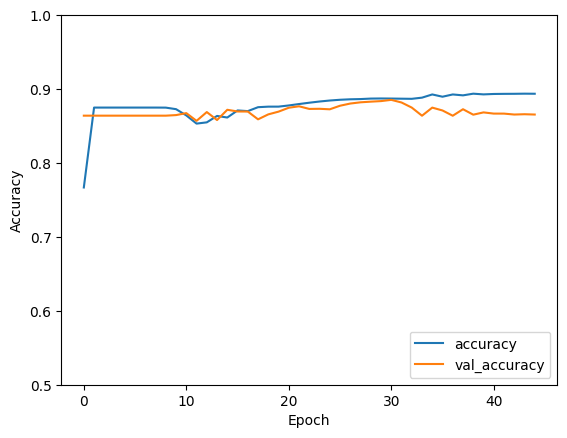

In [ ]:
# plot the accuracy on training and val datasets
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

* The accuracy curves for both training and validation datasets have nearly converged.

* Overall accuracy ranges between 0.8 and 0.9.

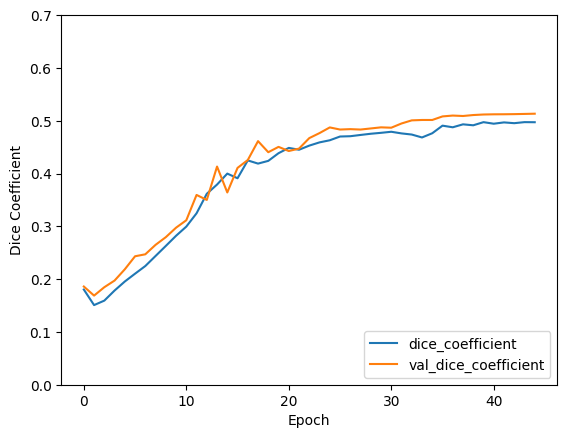

In [ ]:
plt.plot(history.history['dice_coefficient'], label='dice_coefficient')
plt.plot(history.history['val_dice_coefficient'], label = 'val_dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.ylim([0, 0.7])
plt.legend(loc='lower right');

**Observations**:

* The Dice coefficient begins at a low value and gradually increases to approximately 0.5.

* It stabilizes and remains consistent after around 35 epochs.

In [ ]:
# This function converts segmentation mask to boundary boxes
def mask_to_bboxes2(mask, threshold=threshold):
    """
    Converts a binary mask to a list of bounding boxes.
    Each bounding box is in (xmin, ymin, xmax, ymax) format.
    """
    if mask.ndim == 3:
        mask = np.squeeze(mask, axis=-1)

    # Normalize to 0–255 and convert to uint8
    bin_mask = (mask > threshold).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bboxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) > contour_area :  # Filter tiny boxes
            x, y, w, h = cv2.boundingRect(cnt)
            xmin = x / mask.shape[1]
            ymin = y / mask.shape[0]
            xmax = (x + w) / mask.shape[1]
            ymax = (y + h) / mask.shape[0]
            bboxes.append([xmin, ymin, xmax, ymax])

    return bboxes

In [ ]:
def mask_to_bboxes(mask, threshold=threshold):
    mask = mask.squeeze()
    binary = (mask > threshold).astype(np.uint8)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 15 and h > 15:  # filter out tiny noise
            bboxes.append([x, y, x + w, y + h])
    return bboxes

In [ ]:
# quick visulaization of single image mask and boundary boxes
def visualize_prediction(image, mask, bboxes):
    img = (image * 255).astype(np.uint8).copy()
    for (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), thickness=1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title('Predicted BBoxes')
    plt.show()

In [ ]:
# get inference
# This function returns the predicted mask and predicted bounding box
def get_unet_inference(img):
  pred_mask = model.predict(np.expand_dims(img, axis=0), verbose=False)[0]
  bboxes = mask_to_bboxes(pred_mask)
  return pred_mask, bboxes

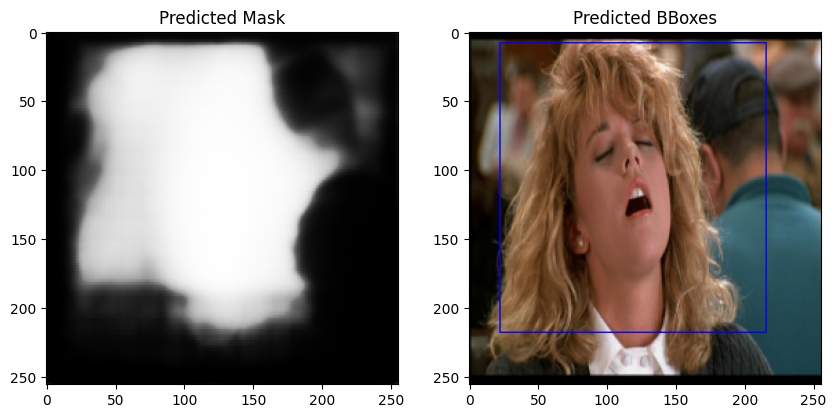

In [ ]:
# Lets take one image from test dataset and analyze the inference
idx =375
pred_mask, bboxes = get_unet_inference(X[idx])
visualize_prediction(X[idx], pred_mask, bboxes)

**Observations**:
* The predicted face segmentation mask is generally accurate but tends to merge with nearby objects.

* As a result, the bounding box often includes adjacent non-face regions as well.

In [ ]:
# Lets create a function to plot the images, bounding boxes and masks
def plot_outputs_with_mask_and_bboxes(images, masks, pbboxes_list, bboxes_list=None, labels_list=None, titles=None):
    """
    For each of n images, plots a row of 3:
    - Original image
    - Image with bounding boxes
    - Corresponding mask
    """

    num_images = len(images)
    fig, axs = plt.subplots(num_images, 3, figsize=(10, 15))

    for i in range(num_images):
        img = images[i]
        mask = masks[i].squeeze()
        pbboxes = pbboxes_list[i]
        labels = labels_list[i] if labels_list else None
        title = titles[i] if titles else f"Image {i+1}"

        # 1. Original image with bounding boxes
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"{title} - Original with BBoxes")
        axs[i, 0].axis('off')

        if bboxes_list is not None:
          bboxes = bboxes_list[i]
          for j, box in enumerate(bboxes):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin

            rect = patches.Rectangle((xmin, ymin), width, height,
                                        linewidth=2, edgecolor='g', facecolor='none')
            axs[i,0].add_patch(rect)

        # 2. Predicted segmented mask
        axs[i, 1].axis('off')
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title(f"{title} Predicted Mask")
        axs[i, 1].axis('off')

        # 3. predicted bounding box
        axs[i,2].imshow(img)
        axs[i,2].set_title('Predicted BBoxes')
        axs[i,2].axis('off')

        for j, box in enumerate(pbboxes):
          if len(box) != 4:
            print(f"Image {i}, Box {j}: {box}")
          xmin, ymin, xmax, ymax = box
          width = xmax - xmin
          height = ymax - ymin

          rect = patches.Rectangle((xmin, ymin), width, height,
                                     linewidth=2, edgecolor='b', facecolor='none')
          axs[i,2].add_patch(rect)

    plt.tight_layout()
    plt.show()

In [ ]:
# lets take random 6 images from test images images
np.random.seed(42)
random_test_indices = np.random.choice(np.arange(334, 392),size=6, replace=False)
random_test_images = []
random_test_bboxes = []
random_pred_masks = []
random_pred_bboxes = []
for i in random_test_indices:
  random_test_images.append(X[i])
  image_bboxes = []
  for ann in all_annotations[i]:
    image_bboxes.append(get_bounding_box(ann))
  pred_mask, pred_bboxes = get_unet_inference(X[i])
  random_test_bboxes.append(image_bboxes)
  random_pred_masks.append(pred_mask)
  random_pred_bboxes.append(pred_bboxes)

In [ ]:
random_test_indices

array([334, 339, 368, 347, 378, 386])

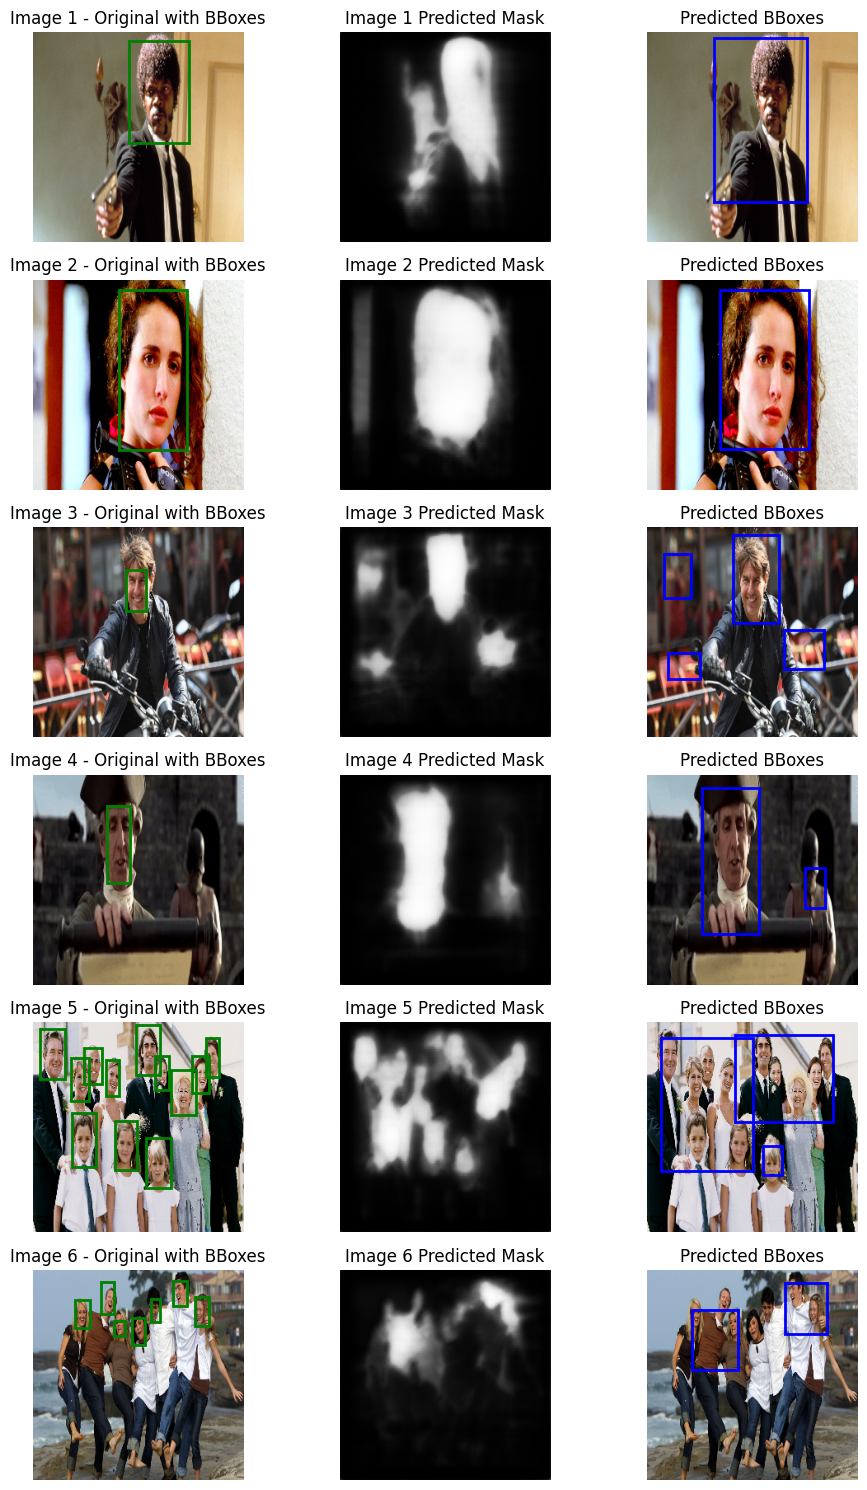

In [ ]:
plot_outputs_with_mask_and_bboxes(random_test_images, random_pred_masks, random_pred_bboxes,  random_test_bboxes)

**Observations**

* Some faces in the images are accurately detected by the model.

* Certain faces are missed and not identified at all.

* The model incorrectly classifies some non-face objects as faces.

* In a few cases, even faces without explicit bounding boxes are still correctly predicted.

* When multiple faces are close to each other, the model tends to merge them into a single bounding box.

### Part II - Predicting Face Masks from Images

Read the images and predict the Faces

In [ ]:
# Directories for input and output
input_dir = '/content/drive/MyDrive/ComputerVision/training_images/'
output_dir = '/content/drive/MyDrive/ComputerVision/training_resized_images/'

In [ ]:
# Function that filters the small boxes and return only one box
# this is to avoid box
def area(box):
  x_min, y_min, x_max, y_max = box
  return (x_max - x_min) * (y_max - y_min)

In [ ]:
# Function that prepares the meta data for the given image
def get_face_metadata(bboxes):
  if not bboxes:
    return {
      'label' : None,
      'points' : None,
      'width' : None,
      'height' : None,
      'bbox' : None
    }

  x_min, y_min, x_max, y_max = max(bboxes, key=area)
  face_data = {
      'label' : 'Face',
      'points' : [{'x': x_min, 'y': y_min }, {'x': x_max, 'y': y_max }],
      'width' : x_max - x_min,
      'height' : y_max - y_min,
      'bbox' : [x_min, y_min, x_max, y_max]
  }
  return face_data

#### Detect the Face and create Pandas dataframe

The following tasks are performed

1. Read the image using CV2
2. Resize the images to 256 x 256
3. Normalize the image
4. Make inference on the image and get predicted mask and predicted boundary box
5. compute the Face meta dat using predicted boundary box
6. Add image, Face meta data, predicted mask, predicted boundary to the Pandas data frame

In [ ]:
%%time
import os
import glob

faces_list = [] # meta data for the face
pre_images = [] # image data
pred_mask_list = [] # mask data


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all image files (adjust extensions as needed)
image_paths = glob.glob(os.path.join(input_dir, '*.jpg')) + \
              glob.glob(os.path.join(input_dir, '*.png')) + \
              glob.glob(os.path.join(input_dir, '*.jpeg'))

# Resize and save
for img_path in image_paths:
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # --- Resize image using TensorFlow ---
    image_tensor = tf.convert_to_tensor(rgb_img, dtype=tf.float32)
    resized_image = tf.image.resize(image_tensor, size=(IMG_SIZE, IMG_SIZE))
    resized_image = resized_image.numpy().astype(np.uint8)
    resized_image = resized_image/255.0
    pred_mask, pred_bbox = get_unet_inference(resized_image)
    pre_images.append(resized_image)
    faces_list.append(get_face_metadata(pred_bbox))
    pred_mask_list.append(pred_mask)

df_meta_data = pd.DataFrame({'image':pre_images,'meta_data': faces_list, 'mask': pred_mask_list})

CPU times: user 1min 37s, sys: 4.67 s, total: 1min 41s
Wall time: 2min 9s


#### Analyze one image

In [ ]:
# Make inference for one image
pred_mask, pred_bbox = get_unet_inference(pre_images[0])

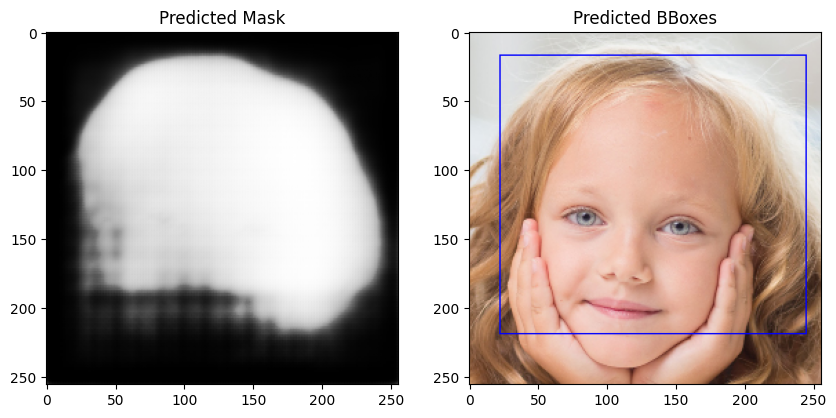

In [ ]:
# Visualize the mask and image
i=0
pred_mask, pred_bbox = get_unet_inference(pre_images[i])
visualize_prediction(pre_images[i], pred_mask, pred_bbox)

**Observations**:

* The predicted mask closely aligns with the actual face region.

* The bounding box accurately encompasses the face.

#### Analyze Pandas dataframe and save the file

The Pandas dataframe is converted to npy file and save to disk

In [ ]:
masks_npy = df_meta_data.to_numpy(dtype=object)

# Save as .npy file
np.save('/content/drive/MyDrive/ComputerVision/training_resized_images/', masks_npy)

In [ ]:
# print 5 records
df_meta_data.head()

image  \
0  [[[0.8392156862745098, 0.8470588235294118, 0.8...   
1  [[[0.9647058823529412, 0.796078431372549, 0.58...   
2  [[[0.7607843137254902, 0.5764705882352941, 0.5...   
3  [[[0.996078431372549, 0.9529411764705882, 0.93...   
4  [[[0.611764705882353, 0.6588235294117647, 0.72...   

                                           meta_data  \
0  {'label': 'Face', 'points': [{'x': 22, 'y': 17...   
1  {'label': 'Face', 'points': [{'x': 18, 'y': 10...   
2  {'label': 'Face', 'points': [{'x': 26, 'y': 22...   
3  {'label': 'Face', 'points': [{'x': 20, 'y': 7}...   
4  {'label': 'Face', 'points': [{'x': 37, 'y': 37...   

                                                mask  
0  [[[0.16840845], [0.076872304], [0.045756605], ...  
1  [[[0.20307855], [0.10946857], [0.0713737], [0....  
2  [[[0.18699159], [0.09482431], [0.06065729], [0...  
3  [[[0.17381874], [0.082724564], [0.050967045], ...  
4  [[[0.18939748], [0.09394488], [0.059114136], [...

In [ ]:
# print the meta data for one image from Pandas data frame
df_meta_data.iloc[0]['meta_data']

{'label': 'Face',
 'points': [{'x': 22, 'y': 17}, {'x': 244, 'y': 219}],
 'width': 222,
 'height': 202,
 'bbox': [22, 17, 244, 219]}

**Observations**

The output above verifies the metadata associated with each face in the image:

* Label: Face

* Points: Coordinates in the format (xmin, ymin), (xmax, ymax)

* Height: Height of the face mask

* Width: Width of the face mask

* BBox: Bounding box represented as a list

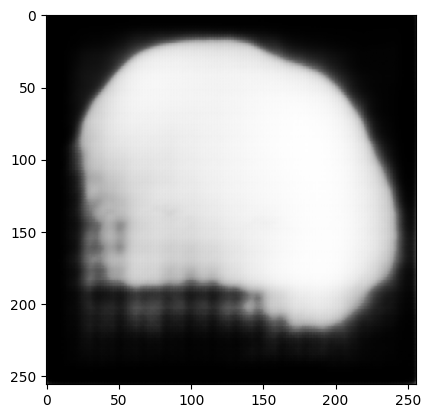

In [ ]:
# print the face mask of the image from Pandas data frame
plt.imshow(df_meta_data.iloc[0]['mask'].squeeze(), cmap='gray')

* The Pandas DataFrame accurately holds the face mask data.

#### Part II - Visualize the predicted Face mask and bounding box

In [ ]:
# Pick random samples from the pedicted output
random_images = []
random_pred_masks = []
random_pred_bboxes = []

for i in df_meta_data.sample(6, random_state=2).index:
  random_images.append(df_meta_data.iloc[i]['image'])
  random_pred_masks.append(df_meta_data.iloc[i]['mask'])
  random_pred_bboxes.append([df_meta_data.iloc[i]['meta_data']['bbox']])

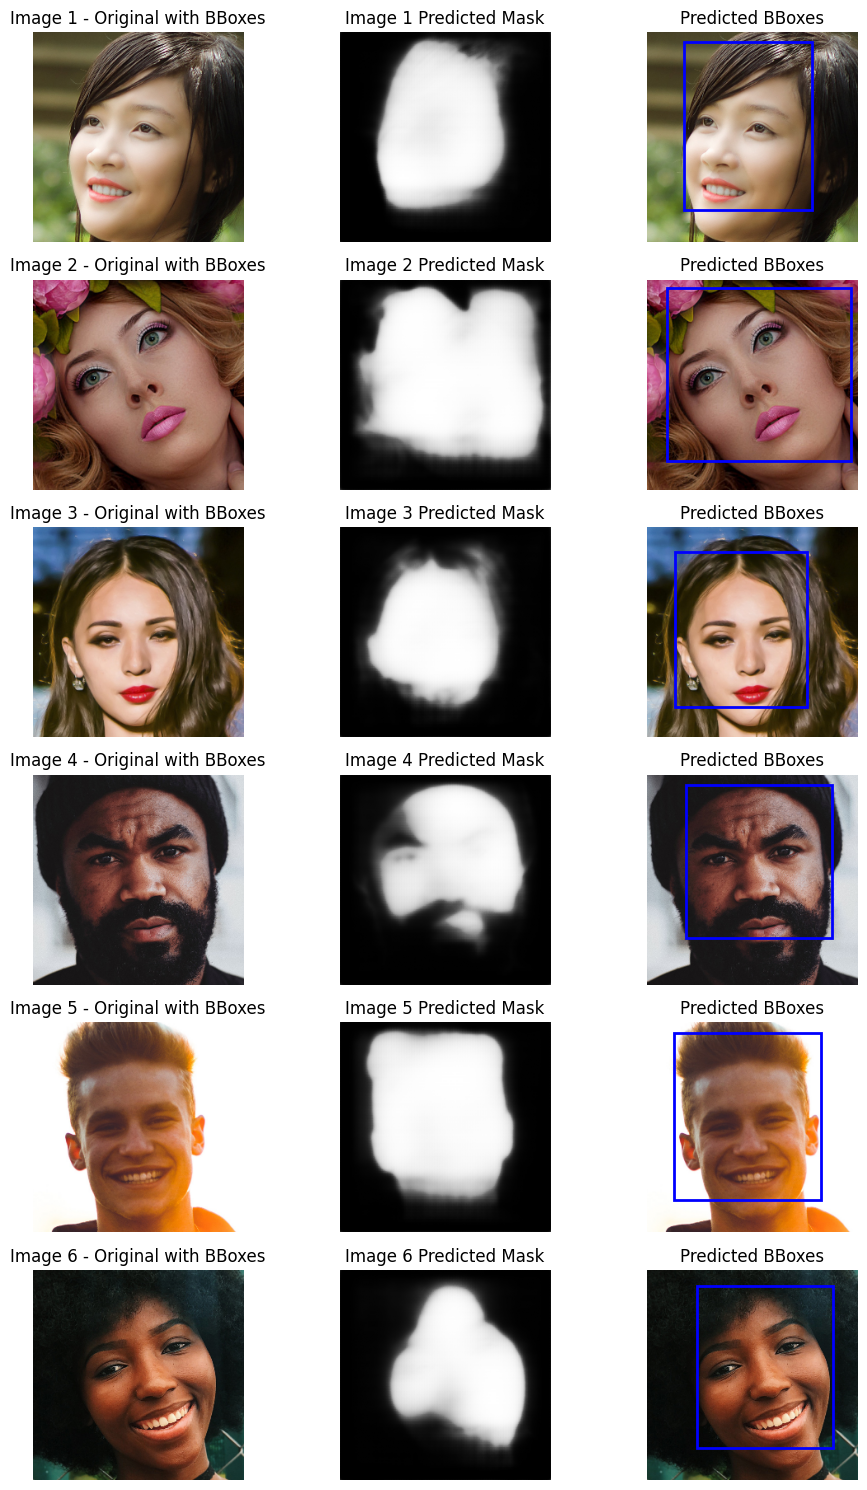

In [ ]:
# Call the visualize function
plot_outputs_with_mask_and_bboxes(random_images, random_pred_masks, random_pred_bboxes)

**Observations**:

* The predicted face masks are fairly accurate.

* The bounding boxes effectively enclose the faces.

* Smaller bounding boxes are discarded, as they are likely to represent noise.

### Part III : Face Recognition

#### Import the data

In [ ]:
%%time
# Use zipfile to extract the images
zip_path = '/content/drive/MyDrive/ComputerVision/PINS.zip'
extract_path = '/content/drive/MyDrive/ComputerVision/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

CPU times: user 4.11 s, sys: 1.94 s, total: 6.05 s
Wall time: 1min 41s


#### Prepare Meta data

In [ ]:
# create a class to identify the meta data
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name

        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [ ]:
# Function that loads the numpy array list for the meta data
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [ ]:
# load the metadata
metadata = load_metadata("/content/drive/MyDrive/ComputerVision/PINS/")

In [ ]:
# print the shape
metadata.shape

(10770,)


* This numpy array contains metadata for 10,770 images

In [ ]:
# print the meta data
print(f"Name : {metadata[0].name}")
print(f"File : {metadata[0].file}")
print(f"Image Path : {metadata[0].image_path()}")

Name : pins_anne hathaway
File : anne hathaway0.jpg
Image Path : /content/drive/MyDrive/ComputerVision/PINS/pins_anne hathaway/anne hathaway0.jpg


#### Load the image

In [ ]:
# Function to convert the image to BGR colour scheme
def load_image(image_path):
  img_rgb = cv2.imread(image_path)
  img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
  return img_bgr

array([[[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
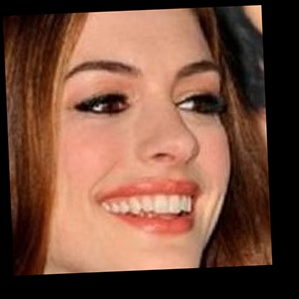

In [ ]:
# Visualize the image
load_image(metadata[0].image_path())

* The image has dimensions of 299 x 299 pixels and contains 3 color channels.

#### Print Labels

In [ ]:
# Extract labels for all images
labels = set()
for md in metadata:
  labels.add(md.name)
len(labels)

100

Images are grouped under about 100 distinct labels.

### Part III: Generate embedding vectors

Lets use the vgg model to generate the embeddings

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Input

def vgg_face():
    model = Sequential()

    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# Use the pretrained weights for the model
model = vgg_face()
model.load_weights('/content/drive/MyDrive/ComputerVision/vgg_face_weights.h5')

In [ ]:
# Initialize the model
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
# summary of the vgg face model
vgg_face_descriptor.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 226, 226, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 226, 226, 64)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 114, 114, 64)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 114, 114, 128)  │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_4                │ (None, 58, 58, 128)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_5                │ (None, 58, 58, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_6                │ (None, 58, 58, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_7                │ (None, 30, 30, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_8                │ (None, 30, 30, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │             

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

There are 145,002,878 pre-trained parameters in this model

In [ ]:
# Get embedding vector for a image in the metadata using the pre-trained model
def get_embedding_vector(img_metadata):
  img_path = img_metadata.image_path()
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))
  #print(img.shape)

  # Obtain embedding vector for an image
  # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0), verbose=0)[0]
  return embedding_vector

In [ ]:
%%time
# Generate the embeddings for all the images
embeddings = []
#embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  if i%500 == 0:
    print(f"{datetime.now()} images processed : {i}")
  embeddings.append(get_embedding_vector(metadata[i]))

2025-07-25 13:52:51.380304 images processed : 0
2025-07-25 13:53:55.431763 images processed : 500
2025-07-25 13:54:53.939831 images processed : 1000
2025-07-25 13:55:52.645926 images processed : 1500
2025-07-25 13:56:52.795610 images processed : 2000
2025-07-25 13:57:52.922313 images processed : 2500
2025-07-25 13:58:52.267871 images processed : 3000
2025-07-25 13:59:50.608625 images processed : 3500
2025-07-25 14:00:50.114314 images processed : 4000
2025-07-25 14:01:50.289094 images processed : 4500
2025-07-25 14:02:50.419596 images processed : 5000
2025-07-25 14:03:49.541716 images processed : 5500
2025-07-25 14:04:48.564481 images processed : 6000
2025-07-25 14:05:46.841089 images processed : 6500
2025-07-25 14:06:46.691709 images processed : 7000
2025-07-25 14:07:46.005463 images processed : 7500
2025-07-25 14:08:45.050756 images processed : 8000
2025-07-25 14:09:43.579692 images processed : 8500
2025-07-25 14:10:41.289995 images processed : 9000
2025-07-25 14:11:41.240038 images p

### Part III: Visualizing similar and disimilar images

Randomly select 15 images for each of the two sets.

Compare the images from both sets using their embedding vectors and the distance between them.

If the distance between two images is less than 20, classify them as similar.

If the distance exceeds 60, classify the images as dissimilar.

In [ ]:
# Random images in dataset 1
np.random.seed(42)
random_files_indices1 = np.random.choice(900, size=15, replace=False)
random_files_indices1

array([ 70, 827, 231, 588,  39, 731, 299, 110,  72,  86, 139, 533, 801,
       120, 711])

In [ ]:
# Random images in dataset2
np.random.seed(1)
random_files_indices2 = np.random.choice(900, size=15, replace=False)
random_files_indices2

array([860, 880, 874, 780, 525,   6, 685, 195, 651, 363,  17, 223, 835,
       748, 600])

In [ ]:
# compute the distance between two embedding vectors
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
# classify the images similar or disiimilar based on the threshold
# Ignore the images that have the threshold between 20 and 60 in the analysis
similar_pairs = []
distinct_pairs = []
for i in random_files_indices1:
  for j in random_files_indices2:
    if i == j:
      continue
    dist = distance(embeddings[i], embeddings[j])
    if dist > distance_threshold_dissimilar:
      #print(f" Distinct Pair : ({i} , {j} ): {dist}")
      distinct_pairs.append((i,j))
    if dist < distance_threshold_similar:
      #print(f" Similar Pair : ({i} , {j} ): {dist}")
      similar_pairs.append((i,j))
print(f"Number of similar images in the randomly chosen images : {len(similar_pairs)}")
print(f"Number of didsimilar images in the randomly chosen images : {len(distinct_pairs)}")

Number of similar images in the randomly chosen images : 3
Number of didsimilar images in the randomly chosen images : 157


In [ ]:
# print first 3 similar pairs
similar_pairs

[(np.int64(110), np.int64(6)),
 (np.int64(711), np.int64(685)),
 (np.int64(711), np.int64(651))]

In [ ]:
# print first 5 dissimilar pairs
distinct_pairs[0:5]

[(np.int64(70), np.int64(860)),
 (np.int64(70), np.int64(874)),
 (np.int64(70), np.int64(780)),
 (np.int64(70), np.int64(685)),
 (np.int64(70), np.int64(195))]

In [ ]:
# Function to plot the pair of images
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.title(metadata[idx1].name)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.title(metadata[idx2].name)
    plt.imshow(load_image(metadata[idx2].image_path()));

#### Plot similar images

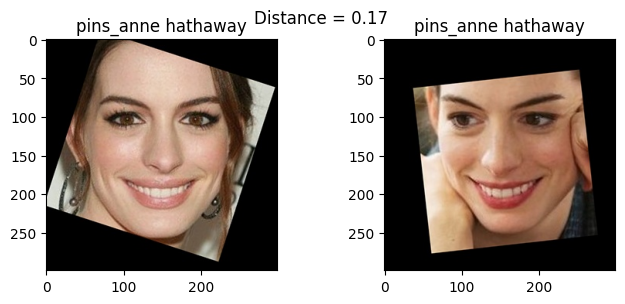

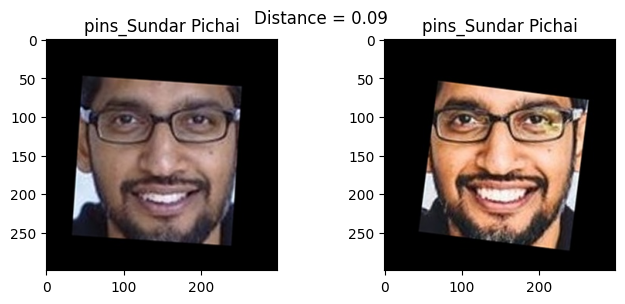

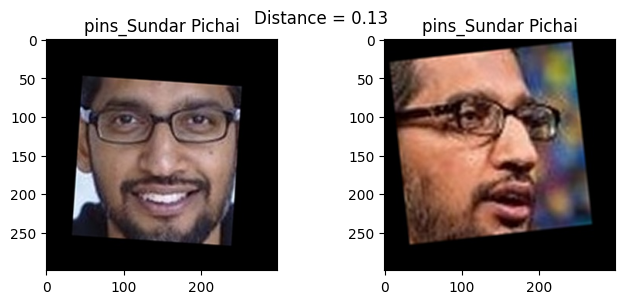

In [ ]:
for i, dpair in enumerate(similar_pairs[0:3]):
  show_pair(similar_pairs[i][0], similar_pairs[i][1])

**Observations**:
* Images belonging to the same person are categorized as similar.

* The distances between similar images appear smaller.

#### Plot distinct pairs

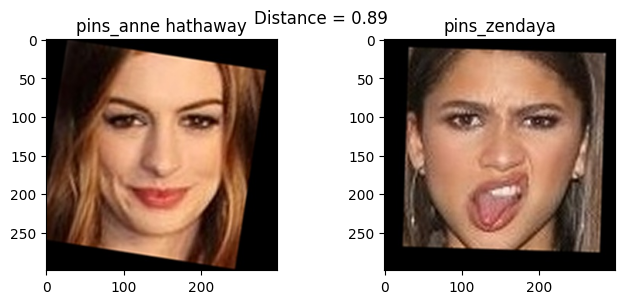

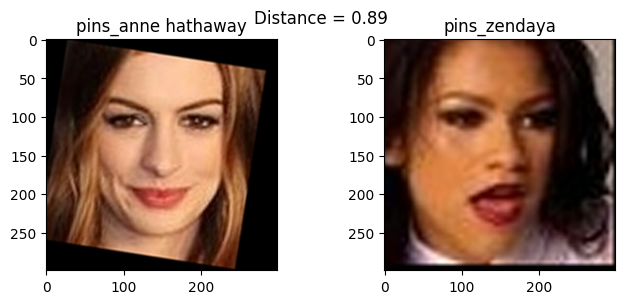

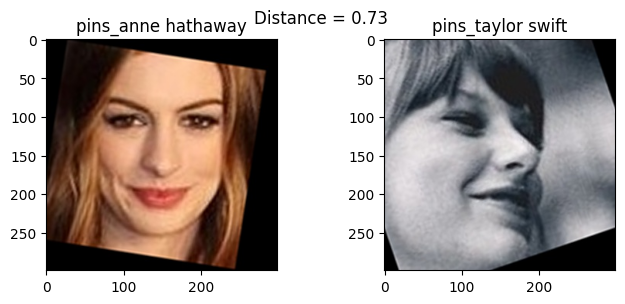

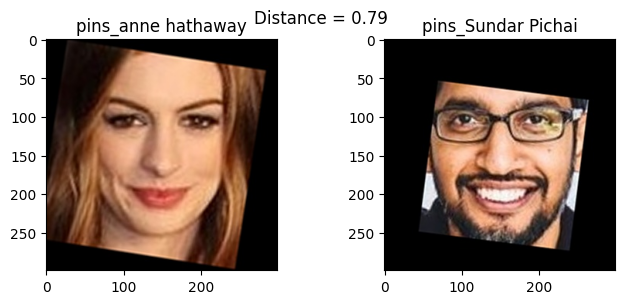

In [ ]:
# plot distinct images for the first 4 images
for i, dpair in enumerate(distinct_pairs[0:4]):
  show_pair(distinct_pairs[i][0], distinct_pairs[i][1])

**Observations**:
* The distinct pairs identified correspond to different people.
* The distance between images of different individuals is significantly larger.

### Part III: Model Building and Inference

#### Split the images

In [ ]:
# split the images into train and test datasets
# Multiples of 9 are pushed to test and remaining to train

embeddings = np.array(embeddings)
indices = np.arange(embeddings.shape[0])

train_idx = indices[indices % 9 != 0]
test_idx = indices[indices % 9 == 0]

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

# print the shapes of input vectors
print(f"Shape of X in train dataset:{X_train.shape}")
print(f"Shape of X in test dataset:{X_test.shape}")

Shape of X in train dataset:(9573, 2622)
Shape of X in test dataset:(1197, 2622)


In [ ]:
# print the shapes of output vector
print(f"Shape of y in train dataset:{y_train.shape}")
print(f"Shape of y in test dataset:{y_test.shape}")

Shape of y in train dataset:(9573,)
Shape of y in test dataset:(1197,)


### Encode the Labels

In [ ]:
# print the names in the testing dataset
np.unique(y_test)

array(['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew',
       'pins_Amaury Nolasco', 'pins_Anna Gunn',
       'pins_Benedict Cumberbatch', 'pins_Betsy Brandt',
       'pins_Brenton Thwaites', 'pins_Brit Marling',
       'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan',
       'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt',
       'pins_Cobie Smulders', 'pins_Danielle Panabaker',
       'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson',
       'pins_Emilia Clarke', 'pins_Emily Bett Rickards',
       'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil',
       'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg',
       'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor',
       'pins_Kit Harington', 'pins_Krysten Ritter',
       'pins_Kumail Nanjiani', 'pins_Maisie Williams',
       'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit',
       'pins_Mike Colter', 'pins_Morena Baccarin', 'p

In [ ]:
# Encode the labels : names of persons
labelEncoder = LabelEncoder()
y_train_en = labelEncoder.fit_transform(y_train)
y_test_en = labelEncoder.transform(y_test)


In [ ]:
# print the encoded y values
np.unique(y_train_en)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
np.unique(y_test_en)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

#### Scale the input vetors

In [ ]:
# print the first element in the input vector
X_train[0]

array([ 0.01114008,  0.00618109,  0.01125835, ..., -0.01791551,
       -0.00546758,  0.02607797], dtype=float32)

In [ ]:
# testing vector
X_test[0]

array([ 0.01230919,  0.00453545,  0.0209086 , ..., -0.0196202 ,
        0.00701474,  0.04137727], dtype=float32)

In [ ]:
# scaling using standard vectors
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
X_train_norm = standardScaler.fit_transform(X_train)
X_test_norm = standardScaler.transform(X_test)

In [ ]:
# first input vector after scaling
X_train_norm[0]

array([ 0.03034982,  0.5475265 ,  0.8036857 , ..., -0.325107  ,
       -1.0752631 ,  0.96529514], dtype=float32)

In [ ]:
# first input vector after scaling in test data
X_test_norm[0]

array([ 0.15306686,  0.40829188,  1.7245755 , ..., -0.4849641 ,
        0.10240246,  2.140925  ], dtype=float32)

#### Apply PCA on the embedding vectors

Reduce the dimensions of the input vector to 128 features using PCA technique

In [ ]:
# shape of train vector before PCA
X_train_norm.shape

(9573, 2622)

In [ ]:
# shape of test vector before PCA
X_test_norm.shape

(1197, 2622)

In [ ]:
# Use PCA model to do the dimensionality reduction
pca = PCA(n_components=128)

X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [ ]:
# shape of train vector after PCA
X_train_pca.shape

(9573, 128)

In [ ]:
# shape of test vector after PCA
X_test_pca.shape

(1197, 128)

* The dimensions of the input vector reduced from 2622 to 128 features

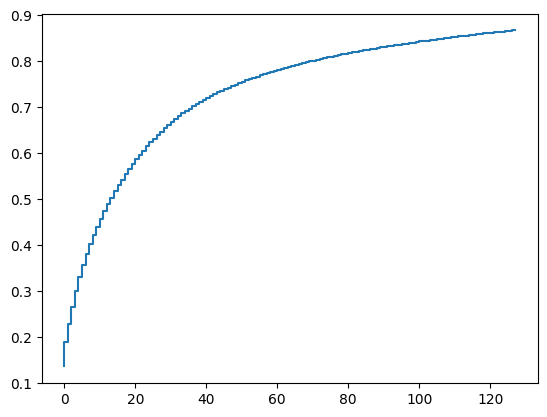

In [ ]:
# plot step graph for cumulative explained ratio
plt.step(list(range(0,128)), np.cumsum(pca.explained_variance_ratio_));

In [ ]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance retained  :", np.sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.135906   0.05381237 0.03957373 0.03691973 0.03378554 0.03158862
 0.02581622 0.02339656 0.02105593 0.0192723  0.01834465 0.01713117
 0.01643741 0.01567023 0.01425219 0.01373866 0.01301053 0.01223489
 0.0115219  0.011385   0.01093472 0.01059631 0.00960146 0.00936854
 0.00904308 0.00873287 0.00837768 0.00773164 0.00766814 0.00734498
 0.00703325 0.00657711 0.00631133 0.0062516  0.00568258 0.00537082
 0.00531158 0.00515384 0.00502259 0.00483172 0.00441494 0.00431614
 0.00398332 0.00390849 0.00370923 0.00354009 0.00343001 0.00333709
 0.00328728 0.00319189 0.00313679 0.00306902 0.00290612 0.00281708
 0.00277067 0.00273973 0.00269222 0.00264216 0.00253199 0.00248894
 0.00238323 0.00232604 0.00224397 0.00216686 0.00213014 0.00204345
 0.00201761 0.00193289 0.00189118 0.00184976 0.0018158  0.00179088
 0.0017618  0.00171581 0.0016852  0.00164698 0.00162359 0.00160179
 0.00157278 0.00155767 0.0015331  0.00148941 0.00146035 0.00143142
 0.00141728 0.00138213 0.00136682 0.

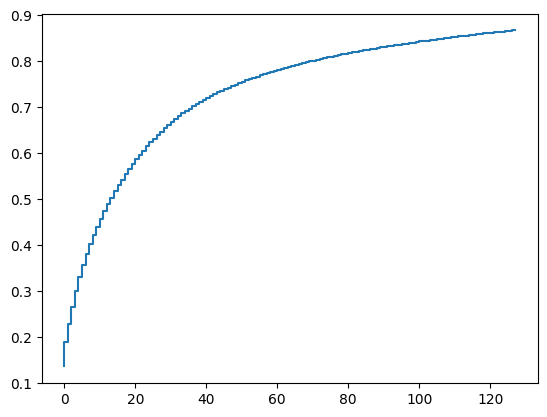

In [ ]:
# plot step graph for cumulative explained ratio
plt.step(list(range(0,128)), np.cumsum(pca.explained_variance_ratio_));

**Observations**

Using 128 features, the model can explain 86.6% of the output

#### SVM Classifier

In [ ]:
# create the SVM classifier and train
clf = SVC(kernel='linear')  # Other kernels: 'rbf', 'poly', etc.
clf.fit(X_train_pca, y_train_en)

SVC(kernel='linear')

In [ ]:
# Make predictions on train data
y_pred_train_en = clf.predict(X_train_pca)
print("Accuracy:", accuracy_score(y_train_en, y_pred_train_en))

Accuracy: 0.9997910790765695


**Observations**:

The model achieved the maximum possible accuracy of 0.99 on the training data

#### SVM Model Evaluation

In [ ]:
# Make predictions on train data
y_pred_en = clf.predict(X_test_pca)
y_test_pred_labels = labelEncoder.inverse_transform(y_pred_en)

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_test_pred_labels))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_labels))

Accuracy: 0.9649122807017544

Classification Report:
                                precision    recall  f1-score   support

              pins_Aaron Paul       1.00      1.00      1.00        10
            pins_Alvaro Morte       0.91      1.00      0.95        10
             pins_Amanda Crew       0.93      1.00      0.96        13
          pins_Amaury Nolasco       1.00      1.00      1.00        13
               pins_Anna Gunn       0.88      1.00      0.93         7
    pins_Benedict Cumberbatch       1.00      1.00      1.00         9
            pins_Betsy Brandt       1.00      0.86      0.92         7
        pins_Brenton Thwaites       1.00      1.00      1.00        14
            pins_Brit Marling       1.00      1.00      1.00        13
          pins_Bryan Cranston       1.00      1.00      1.00         9
              pins_Caity Lotz       0.93      1.00      0.97        14
        pins_Cameron Monaghan       1.00      1.00      1.00        12
          pins_Chance 

**Observations**:

* The evaluation metrics on the test data are excellent.

* The model achieves an accuracy of approximately 0.96 on the test set.

#### Model Inference

In [ ]:
# This function is a pipeline that takes the image as input and returns the
# name of the person in the image
def get_inference(img_path):
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize = (224,224))

  # Obtain embedding vector for an image
  embedding_vector = np.array(vgg_face_descriptor.predict(np.expand_dims(img, axis=0), verbose=0)[0])

  # Flatten the input
  X_test = embedding_vector.reshape(1,2622)

  # scale the input
  X_test_scale = standardScaler.transform(X_test)

  # reduce the dimensions
  X_test_pca = pca.transform(X_test_scale)

  # predict the label
  y_test_pred_en = clf.predict(X_test_pca)

  # convert the number to label
  y_testimg_pred_label = labelEncoder.inverse_transform(y_test_pred_en)

  return y_testimg_pred_label

#### Visualize the test images

In [ ]:
# Add all test images to a list
test_images = []
test_images.append("/content/drive/MyDrive/ComputerVision/Benedict Cumberbatch9.jpg")
test_images.append("/content/drive/MyDrive/ComputerVision/Dwayne Johnson4.jpg")

In [ ]:
# Function to plot the test images
def show_test_images(image_paths, labels=None):
    cols = 2
    n = len(image_paths)
    rows = (n + cols - 1) // cols  # Ceiling division to get rows

    fig, axs = plt.subplots(rows, cols, figsize=(10,4))
    axs = axs.flatten()
    for i in range(len(axs)):
        if i < n:
            img_path = image_paths[i]
            img = cv2.imread(img_path)
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i].imshow(rgb_img)
            #axs[i].axis('off')
            if labels  is not None:
                axs[i].set_title(f"identified as {labels[i]}", fontsize=12)
        else:
            axs[i].axis('off')  # Hide extra subplots

    plt.tight_layout()
    plt.show()

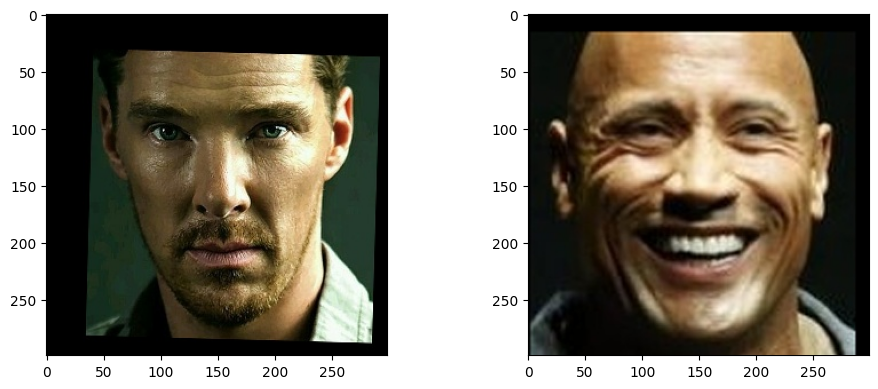

In [ ]:
# plot test images before inference
show_test_images(test_images)

In [ ]:
# Make inference on test images and add it to a list
labels = []
for img_path in test_images:
  labels.append(get_inference(img_path)[0])
labels

[np.str_('pins_Benedict Cumberbatch'), np.str_('pins_Dwayne Johnson')]

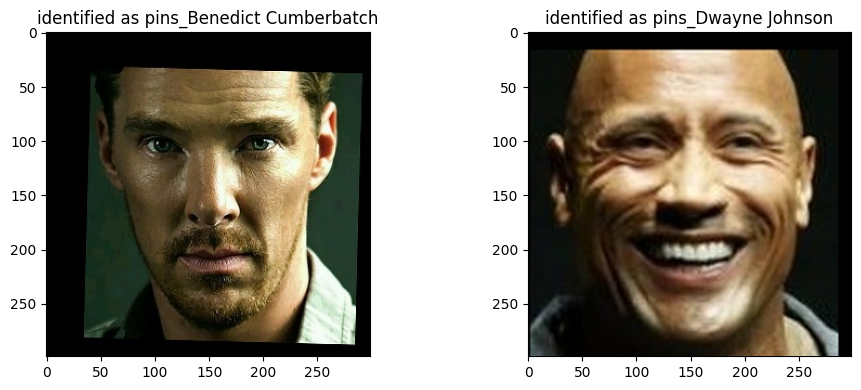

In [ ]:
# Plot test images after with inference
show_test_images(test_images, labels)

**Observations**:

The model correctly inferred the test images.

### Insights and Recommendations

* The current U-Net based face detection model shows limited performance, likely due to its training on bounding box annotations instead of precise segmentation masks.

* Additionally, training with a larger dataset may help improve the model's accuracy and generalization.

* Further exploration of advanced detection models like YOLO or R-CNN that works well with bounding boxes is recommended

* The face recognition model, developed using VGG pre-trained weights and an SVM classifier, is delivering excellent performance with high accuracy and consistent results.

* However, the inference time for generating embedding vectors using the VGG network is relatively high, indicating potential for optimization.

* To enable real-time deployment, further improvements are needed to reduce latency and enhance processing speed.

* Introduce scene-level cast info as an interactive feature to differentiate from competitors.

* Add links to actors' filmographies, interviews, or trivia to increase time spent on the platform.

* Use cast recognition data to offer personalized recommendations based on viewer preferences

* Implement a feedback loop where users can confirm or correct actor information to improve the system over time.

* Build a scene-based index of faces/actors across the movie catalog to improve searchability.

* Introduce sponsored content or merchandise linked to popular actors or characters in a paused scene.